
<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/notebooks/069_Data_Drift_Detection_PSI.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/69_Data_Drift_Detection_PSI.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# 📉 Data Drift Detection: Dlaczego model przestał działać?

Model Machine Learning zakłada, że przyszłość będzie taka sama jak przeszłość. To kłamstwo.
Gdy zmienia się rozkład danych wejściowych (np. klienci są starsi, ceny wyższe), mamy do czynienia z **Data Drift**.

Jak to wykryć automatycznie (monitoring)?

1.  **KS-Test (Kolmogorov-Smirnov):** Porównuje Dystrybuanty (CDF) dwóch rozkładów. Patrzy na maksymalną odległość między nimi.
    *   Zaleta: Bardzo czuły.
    *   Wada: Przy dużych danych "krzyczy" o byle głupstwie (p-value zawsze < 0.05).

2.  **PSI (Population Stability Index):** Metoda binarna (kubełkowa).
    *   Dzielimy dane na kubełki (np. decyle).
    *   Sprawdzamy, ile % danych wpadło do kubełka kiedyś (Reference), a ile teraz (Current).
    *   Wzór: $PSI = \sum (Actual\% - Expected\%) \times \ln(\frac{Actual\%}{Expected\%})$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 1. SYMULACJA DRIFTU
np.random.seed(42)

# Dane Referencyjne (Treningowe) - np. Wiek klientów w 2023 roku
# Średnia 30 lat, odchylenie 5
data_ref = np.random.normal(30, 5, 1000)

# Dane Bieżące (Produkcyjne) - np. Wiek klientów w 2025 roku
# Klienci są starsi (średnia 32) i bardziej zróżnicowani (odchylenie 7)
data_curr = np.random.normal(32, 7, 1000)

print(f"Reference Mean: {np.mean(data_ref):.2f}")
print(f"Current Mean:   {np.mean(data_curr):.2f}")

Reference Mean: 30.10
Current Mean:   32.50


## Wizualizacja Problemu

Zanim policzymy matematykę, rzućmy okiem na histogramy.
Widzimy, że pomarańczowy wykres (Current) jest "przesunięty" i "płaski". To klasyczny Drift.

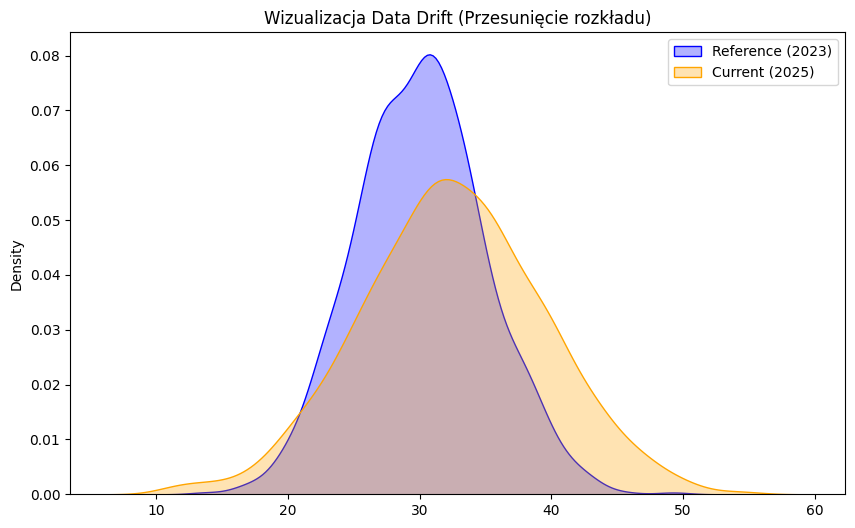

In [2]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data_ref, fill=True, label='Reference (2023)', color='blue', alpha=0.3)
sns.kdeplot(data_curr, fill=True, label='Current (2025)', color='orange', alpha=0.3)
plt.title("Wizualizacja Data Drift (Przesunięcie rozkładu)")
plt.legend()
plt.show()

## Metoda 1: Test Kolmogorova-Smirnova (KS-Test)

Liczymy statystykę KS. Mierzy ona największą odległość między liniami skumulowanymi (CDF).
*   Jeśli p-value < 0.05 -> Rozkłady są RÓŻNE (Alarm!).

KS Statistic: 0.2170
P-value:      0.0000000000
🚨 ALARM KS: Rozkłady różnią się istotnie statystycznie!


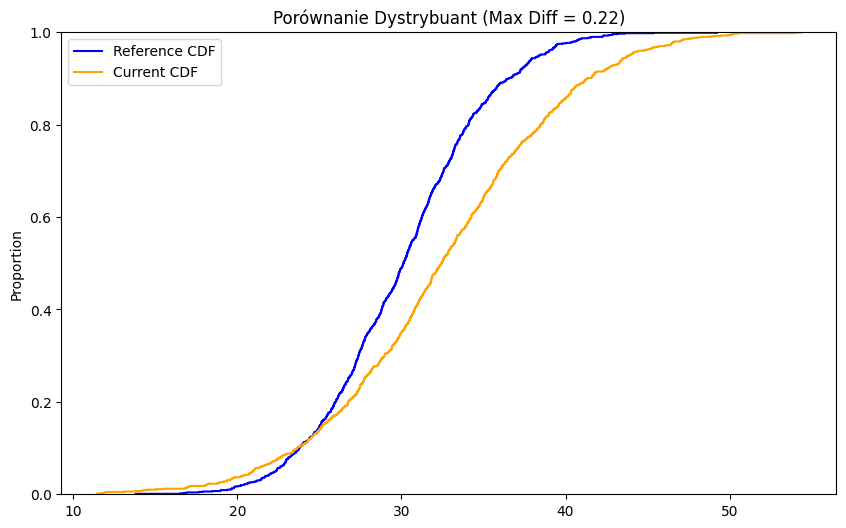

In [3]:
ks_stat, p_value = stats.ks_2samp(data_ref, data_curr)

print(f"KS Statistic: {ks_stat:.4f}")
print(f"P-value:      {p_value:.10f}")

if p_value < 0.05:
    print("🚨 ALARM KS: Rozkłady różnią się istotnie statystycznie!")
else:
    print("✅ KS: Brak zmian.")

# Wizualizacja CDF (To co widzi test KS)
plt.figure(figsize=(10, 6))
sns.ecdfplot(data_ref, label='Reference CDF', color='blue')
sns.ecdfplot(data_curr, label='Current CDF', color='orange')
plt.title(f"Porównanie Dystrybuant (Max Diff = {ks_stat:.2f})")
plt.legend()
plt.show()

## Metoda 2: PSI (Population Stability Index) - Standard w Bankach

KS-Test jest zero-jedynkowy (różne/nie różne).
PSI mówi nam **jak bardzo** są różne.

Interpretacja PSI:
*   **< 0.1**: Brak zmian (Bezpiecznie).
*   **0.1 - 0.25**: Lekki drift (Ostrzeżenie).
*   **> 0.25**: Duży drift (Model do kosza / przeliczenia).

Zaimplementujemy to od zera, używając kubełkowania (Bucketing).

In [4]:
def calculate_psi(expected, actual, bucket_type='bins', buckets=10, axis=0):
    '''Calculate the PSI (population stability index) across all variables'''
    
    def psi(expected_array, actual_array, buckets):
        def scale_range (input, min, max):
            input += -(np.min(input))
            input /= np.max(input) / (max - min)
            input += min
            return input

        # Definiujemy przedziały (breakpoints) na podstawie zbioru referencyjnego
        breakpoints = np.arange(0, buckets + 1) / (buckets) * 100
        breakpoints = np.percentile(expected_array, breakpoints)

        # Liczymy ile % wpada do każdego kubełka
        expected_percents = np.histogram(expected_array, breakpoints)[0] / len(expected_array)
        actual_percents = np.histogram(actual_array, breakpoints)[0] / len(actual_array)

        # Zabezpieczenie przed dzieleniem przez zero (dodajemy epsilon)
        epsilon = 0.0001
        expected_percents = np.where(expected_percents == 0, epsilon, expected_percents)
        actual_percents = np.where(actual_percents == 0, epsilon, actual_percents)

        # Wzór na PSI: (Act% - Exp%) * ln(Act% / Exp%)
        value = (expected_percents - actual_percents) * np.log(expected_percents / actual_percents)
        return np.sum(value)

    return psi(expected, actual, buckets)

psi_value = calculate_psi(data_ref, data_curr, buckets=10)

print("-" * 30)
print(f"Wartość PSI: {psi_value:.4f}")

if psi_value < 0.1:
    print("🟢 STATUS: OK (Brak istotnego driftu)")
elif psi_value < 0.25:
    print("🟡 STATUS: WARNING (Zauważalny drift, monitoruj model)")
else:
    print("🔴 STATUS: CRITICAL (Duży drift! Model wymaga retrenowania)")

------------------------------
Wartość PSI: 0.2609
🔴 STATUS: CRITICAL (Duży drift! Model wymaga retrenowania)


## 🧠 Podsumowanie: Kiedy bić na alarm?

Zobacz wynik.
KS-Test (p-value ~0.000...) krzyczał "ALARM!!!".
PSI (ok. 0.15 - 0.25) mówi "Ostrzeżenie".

**Tu jest haczyk.**
W Big Data (miliony rekordów), nawet minimalna zmiana średniej (z 30.0 na 30.1) sprawi, że KS-Test odrzuci hipotezę zerową (powie, że dane są inne). Ale dla biznesu to bez znaczenia.

Dlatego w MLOps (Monitoring):
1.  Używamy **PSI**, żeby wiedzieć, czy zmiana jest duża (Magnitude).
2.  Używamy **KS**, żeby potwierdzić statystyczną istotność.

Jeśli PSI skoczy powyżej 0.2 -> **Uruchom pipeline retrenowania modelu automatycznie.**